# Практическое задание по занятию Denosing Diffusional Models

ФИО: Лапутин Федор

## Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (2 балла)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


In [1]:
import glob
import sys

import torch
from torch.utils.data import DataLoader
import imageio
import pytorch_lightning as pl

sys.path.insert(0, "./pytorch-diffusion")

from data import DiffSet
from model import DiffusionModel

In [2]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [3]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(
        last_checkpoint,
        in_size=train_dataset.size * train_dataset.size,
        t_range=diffusion_steps,
        img_depth=train_dataset.depth,
    )
else:
    model = DiffusionModel(
        train_dataset.size * train_dataset.size, diffusion_steps, train_dataset.depth
    )

In [4]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch,
    log_every_n_steps=10,
    accelerator="gpu",
    # gpus=1,
    # auto_select_gpus=True,
    # resume_from_checkpoint=last_checkpoint,
    logger=tb_logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# Train model
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Sample from model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

# Generate samples from denoising process
gen_samples = []
x = torch.randn(
    (sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size)
).to(device)
sample_steps = torch.arange(model.t_range - 1, 0, -1)
for t in sample_steps:
    t = t.to(device)
    x = x.to(device)
    x = model.denoise_sample(x, t)
    # x = denoise_sample(model, x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

In [8]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(
    -1,
    gif_shape[0],
    gif_shape[1],
    train_dataset.size,
    train_dataset.size,
    train_dataset.depth,
)


def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)


gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    list(gen_samples.squeeze()),
    duration=5,
)

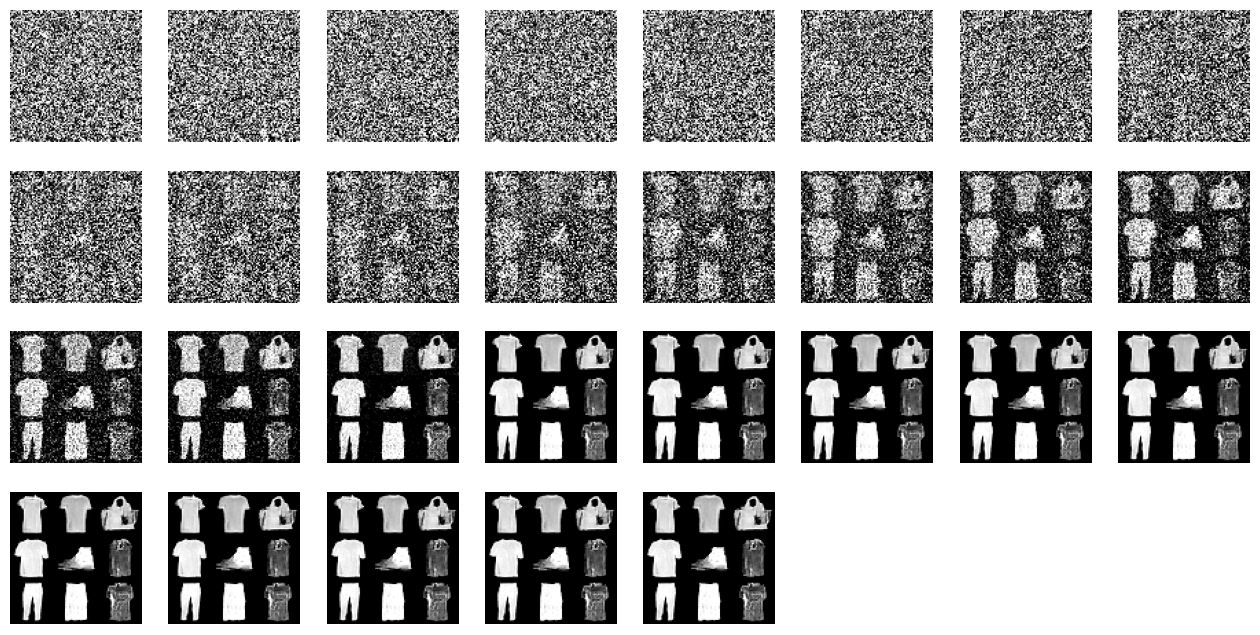

In [9]:
import torch
import matplotlib.pyplot as plt

# Assuming gen_samples is the torch array with shape [29, 96, 96, 1]
# Make sure that it contains valid image data

# Reshape the array to remove the singleton dimension
gen_samples_squeezed = gen_samples.squeeze()

# Convert torch tensor to numpy array
gen_samples_np = gen_samples_squeezed.numpy()

# Plot the images
num_images = gen_samples_np.shape[0]
rows = 4
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

for i in range(num_images):
    ax = axes[i // cols, i % cols]
    ax.imshow(gen_samples_np[i], cmap="gray")  # Assuming grayscale images
    ax.axis("off")

# Hide any remaining axes
for i in range(num_images, rows * cols):
    axes[i // cols, i % cols].axis("off")

plt.show()

Conditional

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms

sys.path.insert(0, "./CFG_DDPM")

from modules_condition import UNetConditional
from model_condition import Diffusion
from utils import plot_images, save_images

In [2]:
class DiffSet(Dataset):
    def __init__(self, train):
        transform = transforms.Compose([transforms.ToTensor()])

        self.train_dataset = FashionMNIST(
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(self.train_dataset.data)

        pad = transforms.Pad(2)
        data = pad(self.train_dataset.data)
        data = data.unsqueeze(3)
        self.depth = 1
        self.size = 32

        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        return self.input_seq[item], self.train_dataset.targets[item]

In [3]:
dataset = DiffSet(train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
num_classes = 10
lr = 3e-4
image_size = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
epochs = 10
run_name = "DDPM_conditional"
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs(os.path.join("models", run_name), exist_ok=True)
os.makedirs(os.path.join("results", run_name), exist_ok=True)

model = UNetConditional(c_in=1, c_out=1, num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=image_size, device=device)

100%|██████████| 469/469 [00:51<00:00,  9.10it/s, MSE=0.0597]
07:50:59 - INFO: Sampling 10 new images....
999it [00:27, 36.46it/s]


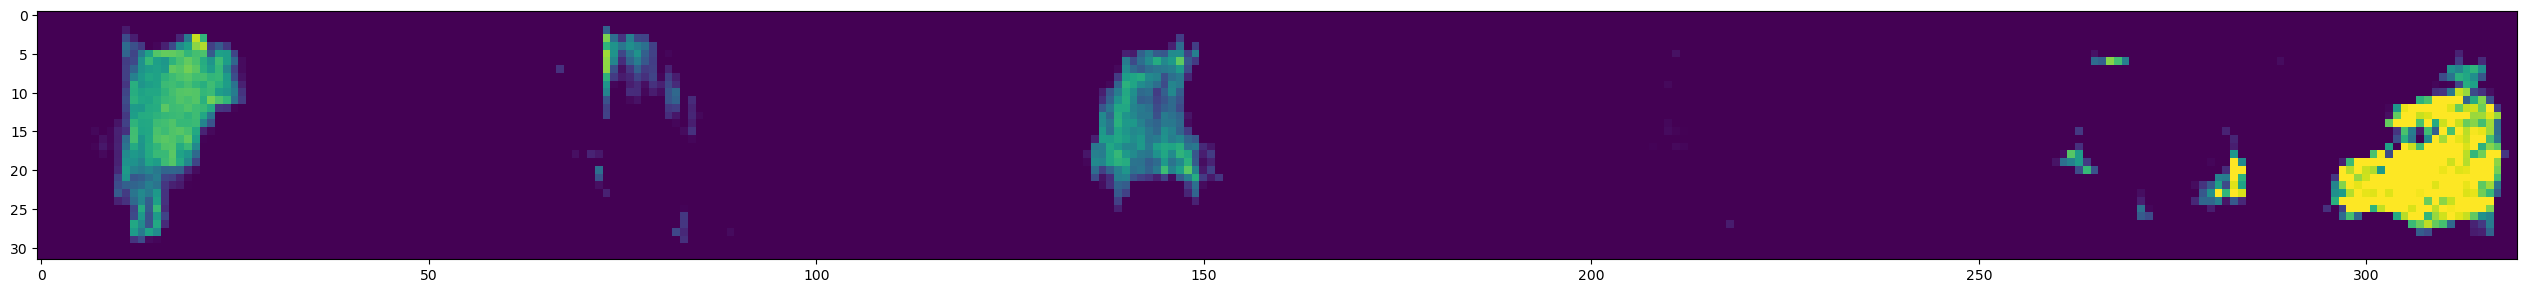

100%|██████████| 469/469 [00:48<00:00,  9.58it/s, MSE=0.0295]


In [5]:
for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for i, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        if np.random.random() < 0.1:
            labels = None
        predicted_noise = model(x_t, t, labels)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())

    if epoch % 10 == 0:
        labels = torch.arange(10).long().to(device)
        sampled_images = diffusion.sample(model, n=len(labels), labels=labels)

        plot_images(sampled_images)
        save_images(sampled_images, os.path.join("results", run_name, f"{epoch}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(
            optimizer.state_dict(),
            os.path.join("models", run_name, f"optim.pt"),
        )

- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

08:01:11 - INFO: Sampling 10 new images....
999it [00:14, 69.72it/s]


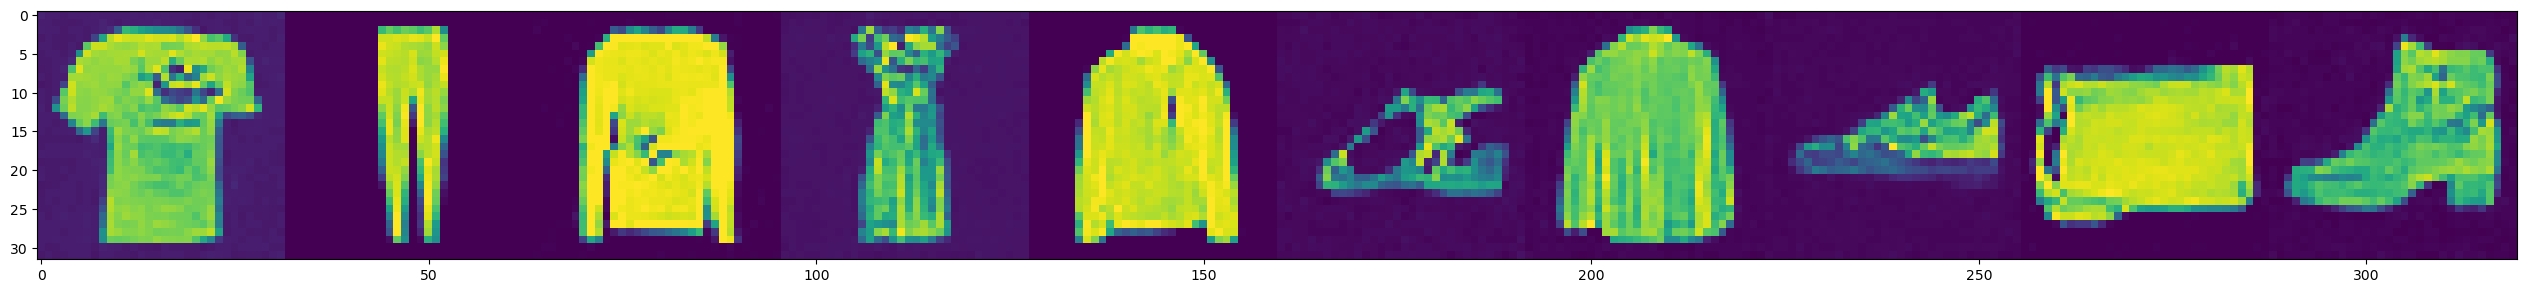

In [7]:
labels = torch.arange(10).long().to(device)
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)

plot_images(sampled_images)
save_images(sampled_images, os.path.join("results", run_name, f"{epoch}.jpg"))
torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
torch.save(
    optimizer.state_dict(),
    os.path.join("models", run_name, f"optim.pt"),
)